In [1]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
#% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Defining the functions which will enable us to read the text file

In [2]:
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [3]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
data = read_text("../input/france/fra.txt")
fra_eng = to_lines(data)
fra_eng = array(fra_eng)

In [5]:
fra_eng

array([['Go.', 'Va !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       ['Hi.', 'Salut !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)'],
       ['Hi.', 'Salut.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)'],
       ...,
       ["Death is something that we're often discouraged to talk about or even think about, but I've realized that preparing for death is one of the most empowering things you can do. Thinking about death clarifies your life.",
        "La mort est une chose qu'on nous décourage souvent de discuter ou même de penser mais j'ai pris conscience que se préparer à la mort est l'une des choses que nous puissions faire qui nous investit le plus de responsabilité. Réfléchir à la mort clarifie notre vie.",
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1969892 (davearms) & #1969962 (sacredceltic)'],
       ['Since there are usually multiple 

We're limiting our sentence pairs to 75000 for ease of training

In [6]:
fra_eng = fra_eng[:75000,:]

In [7]:
fra_eng

array([['Go.', 'Va !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       ['Hi.', 'Salut !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)'],
       ['Hi.', 'Salut.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)'],
       ...,
       ['Can I get a second opinion?',
        'Puis-je avoir une seconde opinion\xa0?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3328496 (CK) & #8010639 (Aiji)'],
       ['Can I get something to eat?',
        'Puis-je avoir quelque chose à manger\u202f?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #528520 (fanty) & #392080 (Sushiman)'],
       ['Can I get you a cup of tea?', 'Tu veux une tasse de thé ?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4013105 (CK) & #7960162 (Micsmithel)']],
      dtype='<U325')

We'll now get rid of all the punctuations in both the english and french phrases by using maketrans

In [8]:
fra_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,0]]
fra_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fra_eng[:,1]]

In [9]:
fra_eng

array([['Go', 'Va ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       ['Hi', 'Salut ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)'],
       ['Hi', 'Salut',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)'],
       ...,
       ['Can I get a second opinion',
        'Puisje avoir une seconde opinion\xa0',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3328496 (CK) & #8010639 (Aiji)'],
       ['Can I get something to eat',
        'Puisje avoir quelque chose à manger\u202f',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #528520 (fanty) & #392080 (Sushiman)'],
       ['Can I get you a cup of tea', 'Tu veux une tasse de thé ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4013105 (CK) & #7960162 (Micsmithel)']],
      dtype='<U325')

Converting the text to lower case

In [10]:
for i in range(len(fra_eng)):
    fra_eng[i,0] = fra_eng[i,0].lower()
    
    fra_eng[i,1] = fra_eng[i,1].lower()

In [11]:
eng_l = []
fra_l = []

# populate the language lists with sentence lengths
for i in fra_eng[:,0]:
    eng_l.append(len(i.split()))

for i in fra_eng[:,1]:
    fra_l.append(len(i.split()))

In [12]:

length_df = pd.DataFrame({'eng':eng_l, 'fra':fra_l})

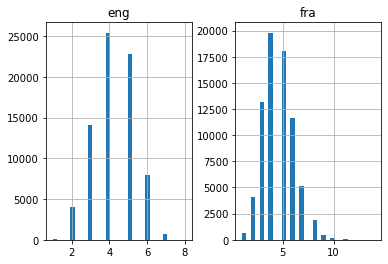

In [13]:
length_df.hist(bins = 30)
plt.show()

#The plot shows frequency of occurence v/s length of phrase for both languages

In [14]:
length_df['eng'].value_counts()

4    25399
5    22796
3    14085
6     7956
2     4041
7      664
1       51
8        8
Name: eng, dtype: int64

We can see that the maximum length sequence in english is 8

In [15]:
length_df['fra'].value_counts()

4     19790
5     18016
3     13171
6     11629
7      5119
2      4076
8      1858
1       680
9       471
10      147
11       38
12        4
14        1
Name: fra, dtype: int64

We can see that the maximum length sequence in French is 14

In [16]:
#Tokenization is the process of converting each word in the vocabulary into an integer based on frequency of occurence

def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

eng_tokenizer = tokenization(fra_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

fra_tokenizer = tokenization(fra_eng[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1

fra_length = 14
print('French Vocabulary Size: %d' % fra_vocab_size)


English Vocabulary Size: 7524
French Vocabulary Size: 17872


In [17]:
# encode and pad sequences
#encoding means replacing each word with its corresponding number
#Padding essentially means adding zeros to make the length of every sequence equal
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq 

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(fra_eng, test_size=0.2, random_state = 12)

In [19]:
trainX = encode_sequences(fra_tokenizer, fra_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

testX = encode_sequences(fra_tokenizer, fra_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Now we'll build the Sequential model.
The first layer is the embedding layer which projects each token in an N dimensional vector space
LSTM is the artificial recurrent neural net architecture.
It can not only proces past data but take feedback from future data as well.

In the second LSTM layer, we have set return sequences as True becuase we need outputs of all hidden units and not just the last one.

In [20]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

model = build_model(fra_vocab_size, eng_vocab_size, fra_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 512)           9150464   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 8, 7524)           3859812   
Total params: 17,208,676
Trainable params: 17,208,676
Non-trainable params: 0
_________________________________________________________________


In [22]:
filename = 'model.h1.25_sep_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
94/94 [==============================] - ETA: 0s - loss: 3.7028
Epoch 00001: val_loss improved from inf to 3.27851, saving model to model.h1.25_sep_20
94/94 [==============================] - 30s 322ms/step - loss: 3.7028 - val_loss: 3.2785
Epoch 2/30
94/94 [==============================] - ETA: 0s - loss: 3.1406
Epoch 00002: val_loss improved from 3.27851 to 3.06480, saving model to model.h1.25_sep_20
94/94 [==============================] - 28s 299ms/step - loss: 3.1406 - val_loss: 3.0648
Epoch 3/30
94/94 [==============================] - ETA: 0s - loss: 2.9083
Epoch 00003: val_loss improved from 3.06480 to 2.83141, saving model to model.h1.25_sep_20
94/94 [==============================] - 28s 303ms/step - loss: 2.9083 - val_loss: 2.8314
Epoch 4/30
94/94 [==============================] - ETA: 0s - loss: 2.6771
Epoch 00004: val_loss improved from 2.83141 to 2.65343, saving model to model.h1.25_sep_20
94/94 [==============================] - 28s 297ms/step - loss: 2.6771

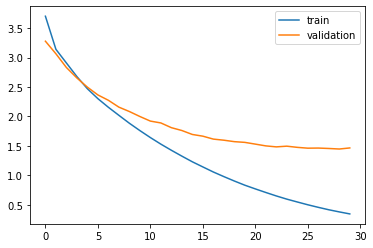

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [27]:
model = load_model('model.h1.25_sep_20')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [28]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [29]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0: #If it is not the first word
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):  #if the next word is same as the previous
                temp.append('')
            else:
                temp.append(t)
             
        else: #if it's not the first word
            if(t == None): #if we didn't get a valid code from dictionary 
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [30]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

In [31]:
pred_df.tail(25)

,actual,predicted
14975,they found each other,they found it
14976,can you cancel,can you cancel
14977,my daughters your age,my father your age
14978,does this belong to you,does this there
14979,tom had nothing to say,tom has nothing to say
14980,dont trust what he says,dont tell what it
14981,youre talkative,youre annoying
14982,i like picnics,i like movies
14983,wheres your mother,wheres your
14984,tom will apologize,tom is


In [37]:

from nltk.translate.bleu_score import sentence_bleu
sumn = 0
for i in range(len(pred_df)):
    reference = pred_df['actual'][0]
    candidate = pred_df['predicted'][1]
    score = sentence_bleu([pred_df['actual'][i].split()],pred_df['predicted'][i].split())
    sumn+=score
    
print("The average BLEU score for the translation is {:.2f} %".format(sumn*100/len(pred_df)))

#Here we have calculated bleu score for every translation and taken an average

The average BLEU score for the translation is 67.00262030400634 %
